# Cargamos utilidades de colab y TaLib





In [3]:
# !git clone https://github.com/b0tm4r/RNN---Divisas.git
from google.colab import drive # Para cargar el disco
from google.colab import files # Para manejar los archivos y, por ejemplo, exportar a su navegador
import glob # Para manejar los archivos y, por ejemplo, exportar a su navegador

drive.mount('/content/drive')
!ls '/content/drive/My Drive' 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'Colab Notebooks'


## TaLib

In [4]:
import os
# download TA-Lib 
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz 
!tar xvzf ta-lib-0.4.0-src.tar.gz
os.chdir('ta-lib') # co-lab no admite cd
!./configure --prefix=/usr
!make
!make install
# wait ~ 30s
os.chdir('../')
!pip install TA-Lib

--2021-01-13 16:13:02--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 216.105.38.13
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|216.105.38.13|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2021-01-13 16:13:02--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 216.105.38.13
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: https://versaweb.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2021-01-13 16:13:02--  https://versaweb.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving versaweb.dl.so

#Importar librerías

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model

import datetime
import talib

## Funciones

Fechas inicial y final del dataframe, para luego componer el nombre del archivo jpg de resultados

In [6]:
def get_fechas(df):
    fecha_final = df.iloc[-1:,:1].values.tolist()[0][0]
    fecha_inicial = df.iloc[0:1,0:1].values.tolist()[0][0]
    date_inicial = datetime.datetime.strptime(fecha_inicial, '%d.%m.%Y')
    date_final = datetime.datetime.strptime(fecha_final, '%d.%m.%Y')
    date_inicial = date_inicial.strftime("%Y-%m-%d")
    date_final = date_final.strftime("%Y-%m-%d")
    return date_inicial, date_final
    


Importar el dataset de entrenamiento

In [7]:
def get_dataframe(dir_path, valor):
    df1 = pd.read_csv(os.path.join(dir_path,'datasets',
                                   "{}.csv".format(valor)))
    df2 = pd.read_csv(os.path.join(dir_path,'datasets',
                                   "{}-total.csv".format(valor)))
    df = pd.concat([df1, df2], ignore_index=True)
    df = df.drop_duplicates(['Fecha'])
    # Datafame reverse xq los datos vienen de mas a menos y reindexamos
    
    df = df.iloc[::-1]
    df = df.reset_index(drop=True)
    # Close
    df['Close'] = df.iloc[:,1:2]
    df['Close'] = df['Close'].apply(lambda x: x.replace(',','.')).astype(float)
    # Open
    df['Open'] = df.iloc[:,2:3]
    df['Open'] = df['Open'].apply(lambda x: x.replace(',','.')).astype(float)
    # High
    df['High'] = df.iloc[:,3:4]
    df['High'] = df['High'].apply(lambda x: x.replace(',','.')).astype(float)
    # Low
    df['Low'] = df.iloc[:,4:5]
    df['Low'] = df['Low'].apply(lambda x: x.replace(',','.')).astype(float)
    # RSI 14
    rsi = talib.RSI(df['Close'])
    df['Rsi'] = rsi
    # Selección de columnas
    df = df.iloc[:,[0,6,7,8,9,10]]
    return df

# Parte 1 - Preprocesado de los datos

In [8]:
dir_path = '/content/drive/My Drive/Colab Notebooks/RNN-Divisas'
periodos_entrenamiento = 60
valor = 'EUR-USD'

periodos_a_predecir = 15

La red se ha creado con dos capas de profundidad,

La primera corresponde al precio, en posicion 1:2 del dataset

La segunda corresponde al rsi, en posicion 5:6 del dataset

Tenemos que replicar el modelo original, que se entrena con las  columnas de  precio de cierre y rsi. 

El precio de cierre lo obtenemos del datasets

El rsi lo vamos a ir calculando

In [9]:
modelo = load_model(os.path.join(dir_path,'models',
                                 "{}-precio-rsi.h5".format(valor)))
dataset_train = get_dataframe(dir_path,valor)
date_inicial, date_final = get_fechas(dataset_train)

data_train = dataset_train.iloc[:, 1:2] 

Calculamos el RSI

In [10]:
rsi = talib.RSI(data_train["Close"])
data_train['Rsi'] = rsi

# Parte 2 - Carga del modelo y predicción

Numero de columnas del dataframe.

Una por cada valor que se haya usado al entrenar el modelo

In [11]:
columnas = 2

Escalado

Si usamos una sola variable para el escalado, al 'desescalar' el precio, que será la predicción, puede que no esté ok, pues hay que usar la misa variable de escalado para las dos cosas.



In [12]:
sc = []
for i in range(0, columnas):
    sc.append(MinMaxScaler(feature_range = (0, 1)))

Realizamos la predicción de un día y la anexamos al datasets. 

En la siguiente iteración esta predicción formará parte del set de datos de entrada para la siguiente predicción

Para eso necesitamos 'closes'

In [17]:
dataset_total = data_train
dataset_total = dataset_total.dropna()
dataset_total = dataset_total.reset_index(drop=True)

closes = data_train['Close'].values

for x in range(0,periodos_a_predecir):
  
    X_test_list = []
    for c in range(0,columnas):
        values = dataset_total.iloc[-periodos_entrenamiento-1:,c:c+1].values
        values.reshape(-1,1)
        values =  sc[c].fit_transform(values)
      
        X_test_data = []
        for i in range(periodos_entrenamiento, values.shape[0]):
            X_test_data.append(values[i-periodos_entrenamiento:i, 0])
                        
        X_test_list.append(np.array(X_test_data))
    
 
    X_test = np.stack(X_test_list, axis=columnas)  # along dimension 2
    
    predicted_stock_price = modelo.predict(X_test)
    predicted_stock_price = sc[0].inverse_transform(predicted_stock_price)
      
    predicted_stock_price_value =  predicted_stock_price[0][0]
      
    ## Generamos de nuevo el dataset_total, anexando la prediccion a la
    ## columna Close y calculamos el RSI
    closes = np.append(closes,predicted_stock_price_value)      
    dataset_total = pd.DataFrame(data=closes, columns=["Close"])
    rsi = talib.RSI(dataset_total["Close"])
    dataset_total['Rsi'] = rsi
    dataset_total = dataset_total.dropna()
    dataset_total = dataset_total.reset_index(drop=True)


# Resultado. Grafico con varios periodos, de mas a menos

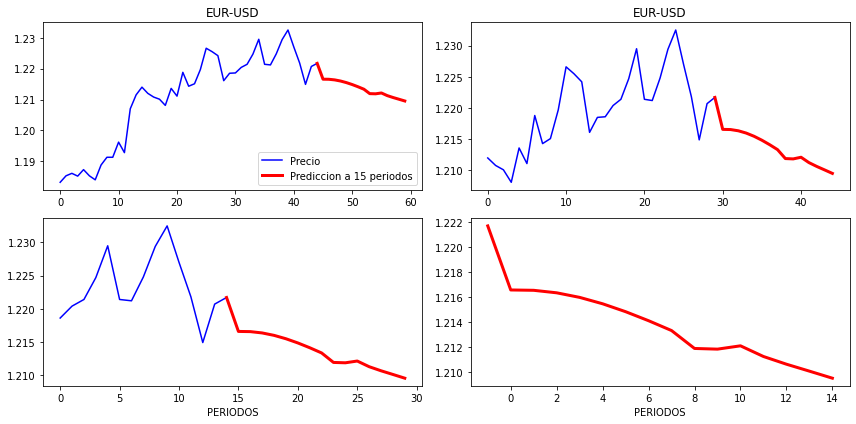

In [18]:
periodos_grafico = [periodos_a_predecir*4,
                    periodos_a_predecir*3,
                    periodos_a_predecir*2,
                    periodos_a_predecir*1]

fig, axs = plt.subplots(2, 2, figsize=(12, 6))

p = periodos_grafico[0]
x = dataset_total.iloc[-periodos_a_predecir-1:,:1].values    
i = p-periodos_a_predecir
y = range(i-1,i+periodos_a_predecir)
axs[0, 0].plot(dataset_total.iloc[-p:-periodos_a_predecir,:1].values, 
               color = 'blue', label = 'Precio')
axs[0, 0].plot(y,x, color = 'red',  linewidth=3, 
               label = 'Prediccion a {} periodos'.format(periodos_a_predecir))
axs[0, 0].set_title("{}".format(valor))
axs[0, 0].legend()

p = periodos_grafico[1]
x = dataset_total.iloc[-periodos_a_predecir-1:,:1].values    
i = p-periodos_a_predecir
y = range(i-1,i+periodos_a_predecir)
axs[0, 1].plot(dataset_total.iloc[-p:-periodos_a_predecir,:1].values, 
               color = 'blue', label = 'Precio')
axs[0, 1].plot(y,x, color = 'red', linewidth=3, 
               label = 'Prediccion a {} periodos'.format(periodos_a_predecir))
axs[0, 1].set_title("{}".format(valor))

p = periodos_grafico[2]
x = dataset_total.iloc[-periodos_a_predecir-1:,:1].values    
i = p-periodos_a_predecir
y = range(i-1,i+periodos_a_predecir)
axs[1, 0].plot(dataset_total.iloc[-p:-periodos_a_predecir,:1].values,
               color = 'blue',  label = 'Precio')
axs[1, 0].plot(y,x, color = 'red', linewidth=3,  
               label = 'Prediccion a {} periodos'.format(periodos_a_predecir))
axs[1, 0].set(xlabel='PERIODOS')

p = periodos_grafico[3]
x = dataset_total.iloc[-periodos_a_predecir-1:,:1].values    
i = p-periodos_a_predecir
y = range(i-1,i+periodos_a_predecir)
axs[1, 1].plot(dataset_total.iloc[-p:-periodos_a_predecir,:1].values, 
               color = 'blue', label = 'Precio')
axs[1, 1].plot(y,x, color = 'red', linewidth=3,  
               label = 'Prediccion a {} periodos'.format(periodos_a_predecir))
axs[1, 1].set(xlabel='PERIODOS')

fig.tight_layout()

filename = os.path.join(dir_path, 'result',
                        '{}-pred-{}-a-{}-periodos.jpg'.format(
                        valor, date_final, periodos_a_predecir
                        ))
fig.savefig(filename)

# Guardamos los resultados a un csv

In [22]:
filename = os.path.join(dir_path, 'result',
                        '{}-pred-{}-a-{}-periodos.csv'.format(
                            valor, date_final, periodos_a_predecir 
                        ))
df = dataset_total.iloc[-periodos_a_predecir:,:].reset_index(drop=True)
df.to_csv(filename, index=True)